# Title/Introduction

## Business Understanding 

## Data Understanding

In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ibtracs.since1980.list.v04r00.csv', dtype='object', parse_dates=True, skiprows=[1])
#drop first row as it's a multi index

pd.set_option('display.max_columns', None)
df.head(3)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,USA_RMW,USA_EYE,TOKYO_LAT,TOKYO_LON,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND,CMA_LAT,CMA_LON,CMA_CAT,CMA_WIND,CMA_PRES,HKO_LAT,HKO_LON,HKO_CAT,HKO_WIND,HKO_PRES,NEWDELHI_LAT,NEWDELHI_LON,NEWDELHI_GRADE,NEWDELHI_WIND,NEWDELHI_PRES,NEWDELHI_CI,NEWDELHI_DP,NEWDELHI_POCI,REUNION_LAT,REUNION_LON,REUNION_TYPE,REUNION_WIND,REUNION_PRES,REUNION_TNUM,REUNION_CI,REUNION_RMW,REUNION_R34_NE,REUNION_R34_SE,REUNION_R34_SW,REUNION_R34_NW,REUNION_R50_NE,REUNION_R50_SE,REUNION_R50_SW,REUNION_R50_NW,REUNION_R64_NE,REUNION_R64_SE,REUNION_R64_SW,REUNION_R64_NW,BOM_LAT,BOM_LON,BOM_TYPE,BOM_WIND,BOM_PRES,BOM_TNUM,BOM_CI,BOM_RMW,BOM_R34_NE,BOM_R34_SE,BOM_R34_SW,BOM_R34_NW,BOM_R50_NE,BOM_R50_SE,BOM_R50_SW,BOM_R50_NW,BOM_R64_NE,BOM_R64_SE,BOM_R64_SW,BOM_R64_NW,BOM_ROCI,BOM_POCI,BOM_EYE,BOM_POS_METHOD,BOM_PRES_METHOD,NADI_LAT,NADI_LON,NADI_CAT,NADI_WIND,NADI_PRES,WELLINGTON_LAT,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5000,172.500,,,,main,647,647,O________OO_O_,jtwc_sh,SH051980,-12.5000,172.500,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-12.5000,172.500,TC,25,,-12.5000,172.500,1,25,,,,,,,-12.5000,172.500,TC,25,,,,,,,,,,,,,,,,,6,351
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.1927,172.441,,,,main,653,653,P________PP_P_,,SH051980,-12.1825,172.432,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-12.1825,172.432,TC,25,,-12.2234,172.469,1,,,,,,,,-12.1825,172.432,TC,25,,,,,,,,,,,,,,,,,6,351
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9144,172.412,,,,main,670,670,O________OP_O_,jtwc_sh,SH051980,-11.9000,172.400,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-11.9000,172.400,TC,25,,-11.9575,172.450,1,,,,,,,,-11.9000,172.400,TC,25,,,,,,,,,,,,,,,,,5,358


The size of the file is really large but it will get smaller throughout the cleaning process. To start off with, there are 163 columns and they are all reading in as object datatypes. I'll need to go through and clean these up.

In [3]:
df.shape

(271883, 163)

In [4]:
df.columns = [x.lower() for x in df.columns]
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271883 entries, 0 to 271882
Data columns (total 163 columns):
sid                 object
season              object
number              object
basin               object
subbasin            object
name                object
iso_time            object
nature              object
lat                 object
lon                 object
wmo_wind            object
wmo_pres            object
wmo_agency          object
track_type          object
dist2land           object
landfall            object
iflag               object
usa_agency          object
usa_atcf_id         object
usa_lat             object
usa_lon             object
usa_record          object
usa_status          object
usa_wind            object
usa_pres            object
usa_sshs            object
usa_r34_ne          object
usa_r34_se          object
usa_r34_sw          object
usa_r34_nw          object
usa_r50_ne          object
usa_r50_se          object
usa_r50_sw          obje

The dataset has readings for storms at multiple points in their progression. There are 4,458 unique storms tracked.

In [5]:
#there are this many separate storms
df['sid'].nunique()

4458

My classification task will be to identify whether they are minor storms or severe Tropical Storms. Looking at my target column, nature, I can see six different classes that I want to sort into two so this will be a binary - severe storm or not severe. 

NR, not reported, and MX, mixture will be removed as they don't tell me anything. TS, tropical storm, will be my '1' - a severe storm. ET, DS, and SS are extratropical, disturbance, and subtropical - less severe storms. These will be my '0' class. 

## Data Exploration & Cleaning

In [6]:
df['nature'].unique()

array(['TS', 'NR', 'ET', 'MX', 'SS', 'DS'], dtype=object)

In [7]:
df.drop(df.loc[df['nature'] == 'NR'].index, inplace=True)
df.drop(df.loc[df['nature'] == 'MX'].index, inplace=True)

In [8]:
#new column  
df['target'] = 0

# loop through the data and input a 1 where the storm is a Tropical storm
for row in df.index:
    if df['nature'][row] == 'TS':
        df['target'][row] = 1

In [9]:
df['target'].value_counts(normalize=True)

1    0.897215
0    0.102785
Name: target, dtype: float64

So there is a pretty severe class imbalance here. Before I address that, I want to define my features. Taking a preliminary look through the columns in the dataframe and the documentation as a guide, I'm selecting the following as potential features to explore. This is a lot less than 163! A lot of these were blank, repeats, or not useful info.

In [10]:
initial_feats = ['sid', 'season', 'basin', 'subbasin', 'lat', 'lon', 
                 'wmo_wind', 'dist2land', 'ds824_wind', 'td9636_stage', 'storm_speed', 'storm_dir']

In [11]:
xs_df = df[initial_feats]
xs_df.head()

,sid,season,basin,subbasin,lat,lon,wmo_wind,dist2land,ds824_wind,td9636_stage,storm_speed,storm_dir
0,1980001S13173,1980,SP,MM,-12.5000,172.500,,647,25,1,6,351
1,1980001S13173,1980,SP,MM,-12.1927,172.441,,653,25,1,6,351
2,1980001S13173,1980,SP,MM,-11.9144,172.412,,670,25,1,5,358
3,1980001S13173,1980,SP,MM,-11.6863,172.435,,682,25,1,4,12
4,1980001S13173,1980,SP,MM,-11.5000,172.500,,703,25,1,4,22


I'm able to convert some of the columns to workable datatypes. Some, that I've listed as 'remaining columns' ran an error as they have empty strings. For now I'm filling those with an actual null so that I am able to work with them.

In [12]:
xs_df[['lat', 'lon', 'dist2land', 'season']] = xs_df[['lat', 'lon', 'dist2land', 'season']].apply(pd.to_numeric)
df['iso_time'] = pd.to_datetime(df['iso_time'])
xs_df['month'] = df['iso_time'].dt.month

In [13]:
remaining_cols = ['wmo_wind', 'ds824_wind', 'td9636_stage', 'storm_speed', 'storm_dir']
xs_df[remaining_cols] = xs_df[remaining_cols].apply(lambda x: x.replace(' ', '0'))
xs_df[remaining_cols] = xs_df[remaining_cols].apply(pd.to_numeric)

In [14]:
xs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226423 entries, 0 to 271072
Data columns (total 13 columns):
sid             226423 non-null object
season          226423 non-null int64
basin           190696 non-null object
subbasin        197687 non-null object
lat             226423 non-null float64
lon             226423 non-null float64
wmo_wind        226423 non-null int64
dist2land       226423 non-null int64
ds824_wind      226423 non-null int64
td9636_stage    226423 non-null int64
storm_speed     226423 non-null int64
storm_dir       226423 non-null int64
month           226423 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 34.2+ MB


In [15]:
y_df = df['target'].to_frame()
clean_df = pd.concat([xs_df, y_df], axis=1)

All of my non-object columns have been converted! There are still null values in the basin & subbasin columns so I'm going to inspect those to see what the best action would be.

From inspecting the mean value for the target column of my data grouped by storm ID, I can see that storms change class over time. Because of this, I'm not going to look at the readings by storm but instead as independent readings to see what conditions change a storm to be severe

In [16]:
grouped_df = clean_df.groupby(['sid']).mean()
# grouped_df['target'].unique()
# example
# clean_df.loc[clean_df['sid'] == '2020307N12250']

In [17]:
clean_df = clean_df.drop('sid', axis=1)

In [18]:
# there were a bunch of empty strings so I just replaced them with  0 for unknown
clean_df['td9636_stage'] = clean_df['td9636_stage'].replace(' ', 0)
clean_df['td9636_stage'].value_counts()

0    186588
2     15923
1     12485
4     10273
3       734
5       228
6       192
Name: td9636_stage, dtype: int64

Stage appears to be target leakage but we can see the relationship isn't 1:1 except in one instance. 

In [19]:
clean_df.groupby(['target']).mean()

,season,lat,lon,wmo_wind,dist2land,ds824_wind,td9636_stage,storm_speed,storm_dir,month
target,,,,,,,,,,
0,2004.657887,26.183926,14.152830,10.345379,844.710480,0.000000,0.049628,14.850986,148.837451,7.733640
1,1998.543692,7.703185,48.142032,21.598198,830.143382,0.976224,0.436928,9.488275,221.142289,7.040369


In [20]:
plot_df = clean_df.drop(['subbasin', 'basin'], axis=1)
plot_df

,season,lat,lon,wmo_wind,dist2land,ds824_wind,td9636_stage,storm_speed,storm_dir,month,target
0,1980,-12.5000,172.5000,0,647,25,1,6,351,1,1
1,1980,-12.1927,172.4410,0,653,25,1,6,351,1,1
2,1980,-11.9144,172.4120,0,670,25,1,5,358,1,1
3,1980,-11.6863,172.4350,0,682,25,1,4,12,1,1
4,1980,-11.5000,172.5000,0,703,25,1,4,22,1,1
...,...,...,...,...,...,...,...,...,...,...,...
271068,2020,13.7116,-86.2234,0,0,0,0,10,272,11,1
271069,2020,13.7333,-86.7667,0,0,0,0,10,273,11,1
271070,2020,13.7690,-87.2733,0,0,0,0,10,274,11,1
271071,2020,13.8000,-87.8000,0,0,0,0,11,272,11,1


In [21]:
# sns.pairplot(plot_df)

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

<Figure size 432x288 with 0 Axes>

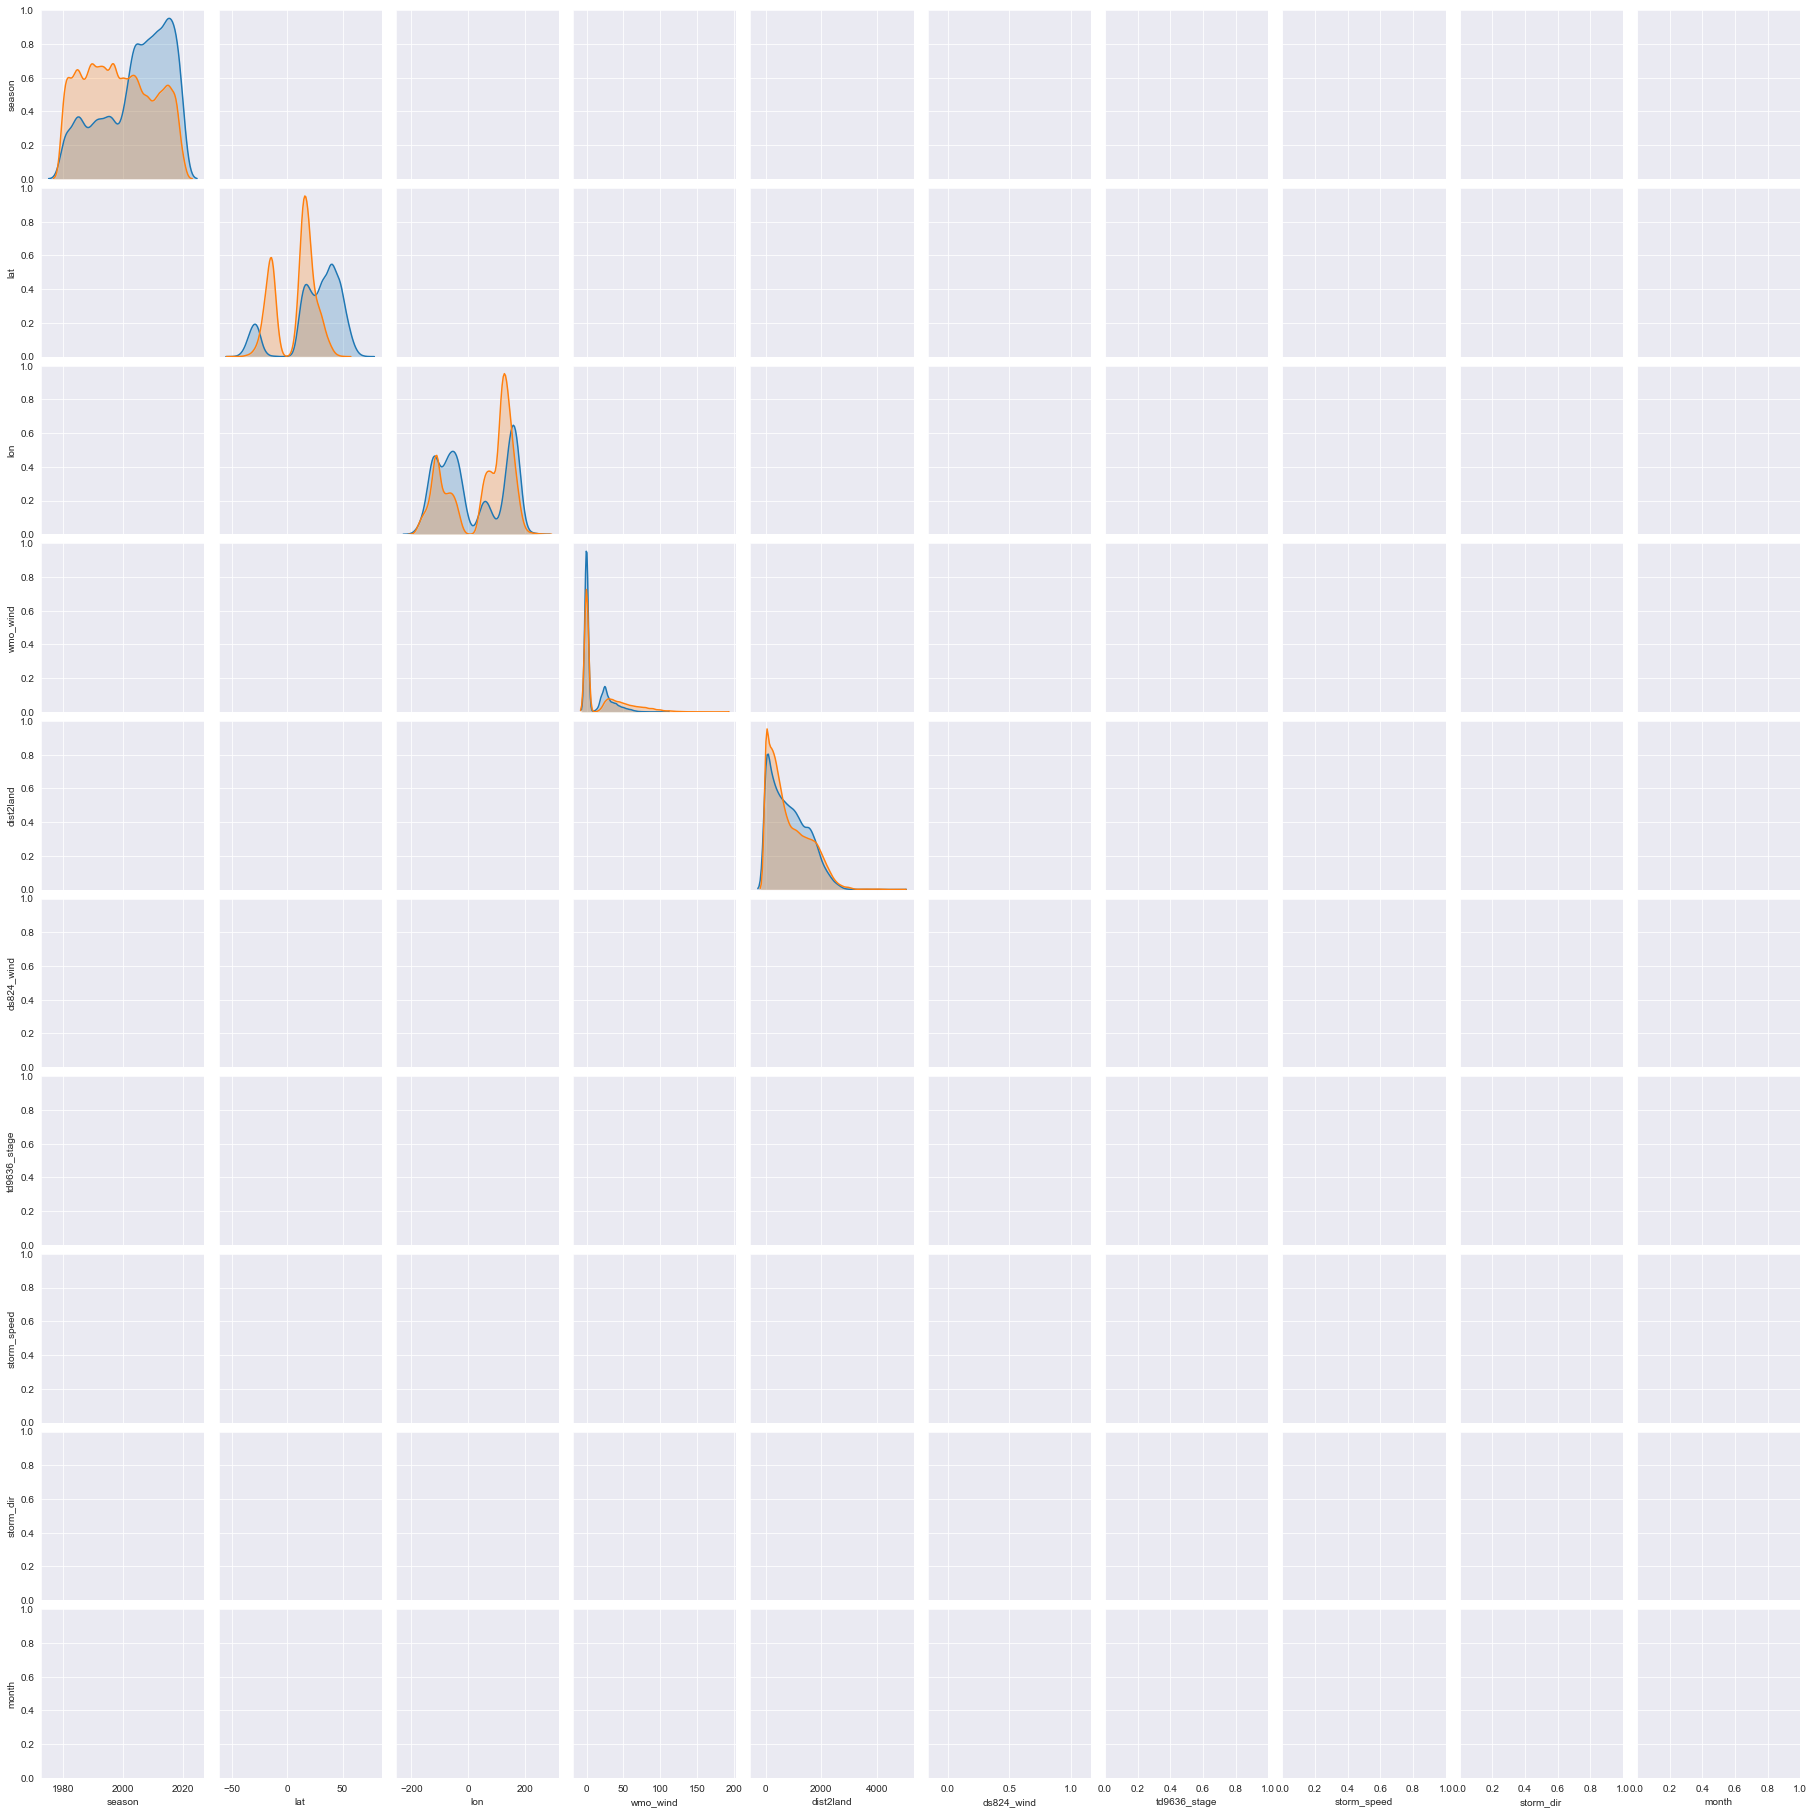

In [45]:
plt.figure()
sns.pairplot(plot_df, hue='target')

(11, 0)

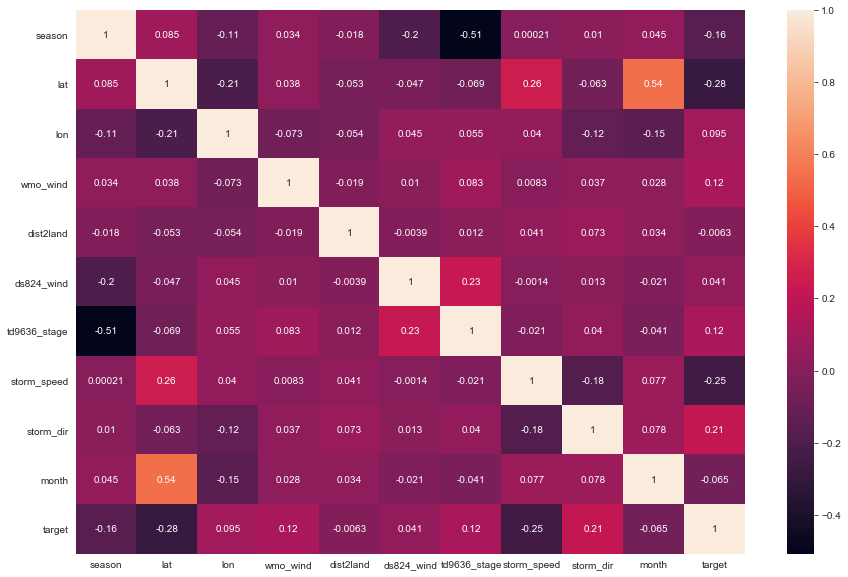

In [26]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(plot_df.corr(), annot=True)
ax.set_ylim(11,0)

My remaining string columns, basin and subbasin, have a solid amount of null values. In trying to handle these, I first took a look at min & max lat/long values to see if I could infer from there but there was overlap. Looking at the documentation I can see that MM, the category within subbasin, is missing. Because this is the most popular category, for both I'll try imputing nulls with the most common value as my best guess. 

In [27]:
clean_df['basin'].value_counts()

WP    75404
SI    48893
EP    41571
SP    20576
NI     4133
SA      119
Name: basin, dtype: int64

In [28]:
clean_df['basin'].isna().sum() / len(clean_df['basin'])

0.1577887405431427

In [29]:
clean_df['subbasin'].value_counts()

MM    154639
WA     17735
EA      7245
CP      6944
CS      3733
GM      3258
BB      2476
AS      1657
Name: subbasin, dtype: int64

In [30]:
clean_df['subbasin'].isna().sum() / len(clean_df['subbasin'])

0.12691290195783997

## Modeling

Simply guessing 1 will mean I am accurate ~90% of the time. I want to account for class imbalance when running my first real model, but first I want to run a baseline.

In [31]:
# Your code here
y = clean_df['target']
X =  clean_df.drop(columns=['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [32]:
X.dtypes

season            int64
basin            object
subbasin         object
lat             float64
lon             float64
wmo_wind          int64
dist2land         int64
ds824_wind        int64
td9636_stage      int64
storm_speed       int64
storm_dir         int64
month             int64
dtype: object

### Preprocessing for first model

For my first baseline model, I'm using a pipeline to imput null values, scale features, and One Hot Encode my categorical objects. I'm going to run Logistic regression and set the 'class weight' parameter to balanced, which adjusts the weighting of each class.

In [33]:
num_cols = []
ohe_cols = []
    
for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].dtype in ['object']:
        ohe_cols.append(c)

In [34]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

ohe_transformer = Pipeline(steps=[
    ('str_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='error'))])


In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols) 
        ])

In [36]:
preprocessor.fit_transform(X_train).shape

(169817, 24)

In [37]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(class_weight='balanced'))])

clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['season', 'lat', 'lon',
                                                   'wmo_wind', 'dist2land',
                                                   'ds824_wind', 'td9636_stage',
                                                   'storm_speed', 'storm_dir',
                                                   'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('str_imputer',
                                             

In [38]:
train_preds = clf_logreg.predict(X_train)
test_preds = clf_logreg.predict(X_test)

### First Model Evaluation

Before I move on, I want to define what evaluation metrics I'll use initially so I know how to optimize my model. 

In this scenario, a false positive would mean that my model flagged a storm as severe when it wasn't. This would mean a false alarm scenarion where resources were spent preparing for a storm that didn't have a large impact. A false negative would mean that a severe hurricane was not flagged, which could cause unsafe conditions and potentially, preventable harm to communities. Although we don't want to waste resources, it's clear that the false negative is the worse outcome, so I will optimize my model to prevent that.

Therefore I want to mainly focus on **recall**, but I also want to run all metrics so I can understand my model's overall strengths and weaknesses.  I'll use classification report for this.

In [39]:
def scores(y_train, train_preds, y_test, test_preds):
    print("Training Score:")
    print(classification_report(y_train, train_preds))
    print("------------------------------------------------------")
    print("Test Score:")
    print(classification_report(y_test, test_preds))

In [40]:
scores(y_train, train_preds, y_test, test_preds)

Training Score:
              precision    recall  f1-score   support

           0       0.29      0.81      0.43     17424
           1       0.97      0.78      0.86    152393

    accuracy                           0.78    169817
   macro avg       0.63      0.79      0.65    169817
weighted avg       0.90      0.78      0.82    169817

------------------------------------------------------
Test Score:
              precision    recall  f1-score   support

           0       0.30      0.81      0.43      5849
           1       0.97      0.78      0.86     50757

    accuracy                           0.78     56606
   macro avg       0.63      0.80      0.65     56606
weighted avg       0.90      0.78      0.82     56606



In [41]:
# import matplotlib.pyplot as plt  
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(clf_logreg, y_test, test_preds)

Preliminary observations: my model seems well fit. My model has pretty good recall and does better on 0s, but is also has really low precision at predicting 0s. The next thing to do is address class imbalance.

AUC for None: 0.8714040970400562
-------------------------------------------------------------------------------------
AUC for Balanced: 0.8792354533690075
-------------------------------------------------------------------------------------
AUC for 2 to 1: 0.8652476257284847
-------------------------------------------------------------------------------------
AUC for 10 to 1: 0.8517893461264535
-------------------------------------------------------------------------------------
AUC for 100 to 1: 0.8397179002600238
-------------------------------------------------------------------------------------
AUC for 1000 to 1: 0.8348466316059657
-------------------------------------------------------------------------------------


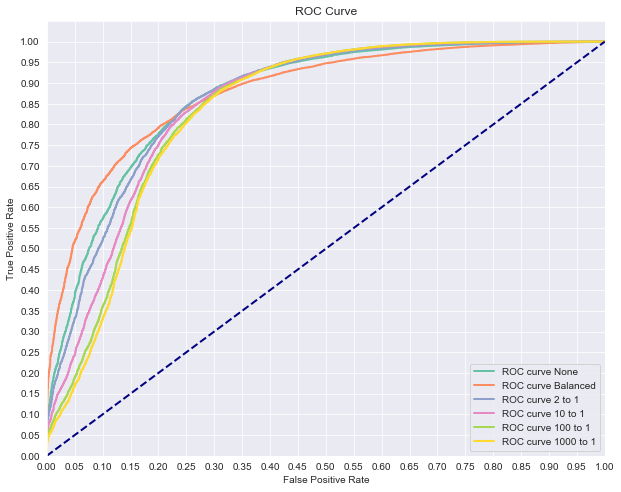

In [42]:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))
for n, weight in enumerate(weights):
    clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(fit_intercept=False, class_weight=weight, C=1000))])

    clf_logreg.fit(X_train, y_train)
    y_score = clf_logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

There's not... a ton of difference. Note: I also tried iterating over different C values and saw barely any difference. I'm going to try a different model type. I want to experiment with tree based models to see what effect it has.

In [43]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier)])


NameError: name 'Deci' is not defined